# Unsupervised Learning

In the Supervised Learning paradigm, we have a collection of observations (our data), each with a set of features and a particular variable of interest, i.e., the "target" (in regression) or "label" (in classification) which we aim to predict.

In the **Unsupervised Learning** paradigm, there is no particular variable of interest. In this way, the goal is not to predict an aspect of, but rather **to organize the data**, and subsequently act on our organization. Most forms of unsupervised learning can be categorized as one of the following:

- **Dimensionality Reduction.** Use relationships between rows and columns to represent the data with fewer columns.
- **Clustering:** Group rows of data into categories based on their featuers ("similar" data are placed into similar groups).
- **Recommendation.** Use the above two strategies to acertain what might be a good recommendation to someone with access to the features of data in question.

And, all three of these are based on the notion of "**similarity**".

*With unsupervised learning, we will mainly use the `.transform()` and `.fit_transform()` methods in Scikit-Learn that we saw in the lab on NLP methods.*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

sns.set_theme(context='notebook', style='whitegrid', font_scale=1.2)

## Train-Test Split

Unsupervised Learning is still a form of "machine" learning, so we grant that our work is meant to generalize to data that is yet unseen. So, we should still have a hold out (or "test") set of data on which to evaluate our models later.

In this lab, we'll be using a collection of beer review data.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# we can use `read_csv` to read the compressed csv file
df_raw = pd.read_csv("./data/beer_reviews.csv.zip", compression='zip', low_memory=False)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   brewery_id          1586614 non-null  int64  
 1   brewery_name        1586599 non-null  object 
 2   review_time         1586614 non-null  int64  
 3   review_overall      1586614 non-null  float64
 4   review_aroma        1586614 non-null  float64
 5   review_appearance   1586614 non-null  float64
 6   review_profilename  1586266 non-null  object 
 7   beer_style          1586614 non-null  object 
 8   review_palate       1586614 non-null  float64
 9   review_taste        1586614 non-null  float64
 10  beer_name           1586614 non-null  object 
 11  beer_abv            1518829 non-null  float64
 12  beer_beerid         1586614 non-null  int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [5]:
df_beer_reviews, df_holdout = train_test_split(df_raw, test_size=0.20, random_state=33)

In [6]:
df_beer_reviews.isna().sum()

brewery_id                0
brewery_name             12
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      272
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              54314
beer_beerid               0
dtype: int64

In [7]:
# there are not many NA values compared to all the data, so we drop them
df_beer_reviews.dropna(inplace=True)

In [8]:
# df_beer_reviews.to_csv('./data/beer_reviews.csv', index=False)
# df_holdout.to_csv('./data/beer_reviews_holdout.csv', index=False)

## The Curse of Dimensionality

As data sets become increasingly wide (i.e., more columns), they in turn become more unweildy. We may want as many columns as possible to maximize the information we have for each observation, but as we do so, we run into a couple of problems:

1. more columns will increase the computational load on any algorithm acting on that data. 
2. high-dimensional spaces quickly become sparse, and require exponentially more data accurately represent a situation.

This phenomenon is commonly called **"The Curse of Dimensionality"**.

## Dimensionality Reduction

We can combat the curse of dimensionality using dimensionality reduction techniques. In dimensionality reduction, we extract latent features in our data that otherwise would go unnoticed (a.k.a., "Feature Extraction"). These latent features retain some acceptable percentage of the information from the original dataset, and we can use a fewer number of them in lieu of the wider dataset we started with. *Note: In a way, classification and regression are extreme forms of dimensionality reduction.*

One of the most common dimensionality reduction techniques is one we've already seen: Principal Components Analysis (PCA) which uses Singular Value Decomposition (SVD). Recall that SVD is a guaranteed decomposition for any rectangular matrix. It creates the following equality:

$$
X = U\Sigma V^\top
$$

In [9]:
from sklearn.decomposition import PCA

### Indexing Entities

Here, we'll use PCA to capture the features of the beers which were reviewed. We'll reduce the dimensionality of our beer data, after converting categorical columns to numeric ones with `get_dummies`. But first, it is often helpful to create meaningful indices for our data. That is, we create a unique index for each row of data, and assign it to the `index` attribute of the data frame.

We'll start by only considering beer-related columns of data.

In [10]:
df_beers = df_beer_reviews.groupby(['beer_name', 'beer_beerid', 'brewery_name', 'beer_style']) \
                          [['review_overall', 'beer_abv']].mean().reset_index()

In [11]:
df_beers.shape

(45516, 6)

In [12]:
print("Number of `beer_beerids`: ", df_beers['beer_beerid'].nunique())
print("Number of `beer_names`: ", df_beers['beer_name'].nunique())

Number of `beer_beerids`:  45516
Number of `beer_names`:  41054


The "names" don't quite match up to their IDs, so we create a unique identifier for each row, and reassign it as the index for the dataframe.

In [13]:
df_beers['beer_id'] = df_beers['beer_name'] + ' (' + df_beers['beer_beerid'].astype(str) + ')'

In [14]:
df_beers['beer_id'].nunique()

45516

In [15]:
df_beers.set_index('beer_id', inplace=True)
df_beers.drop(columns=['beer_beerid', 'beer_name'], inplace=True)

In [16]:
df_beers.drop_duplicates(inplace=True)

Next, we'll reduce our scope to only the top 100 breweries, and the top 100 beer styles.

In [17]:
# Let's just look at the top breweries and the top beer styles
n_breweries = 100
n_beer_styles = 100

# `.value_counts` sorts the series descendingly by default
brewery_popularity = df_beers.brewery_name.value_counts()
top_breweries = brewery_popularity.iloc[:n_breweries].index

beer_style_popularity = df_beers.beer_style.value_counts()
top_beer_styles = beer_style_popularity.iloc[:n_beer_styles].index

df_beers_top = df_beers[(df_beers.brewery_name.isin(top_breweries)) &
                        (df_beers.beer_style.isin(top_beer_styles))].copy()

df_beers_top.shape

(8964, 4)

In [18]:
df_beers_num = pd.get_dummies(df_beers_top)

In [19]:
df_beers_num.shape

(8964, 201)

In [20]:
# proportion of the data which is zero
(df_beers_num == 0).sum().sum() / (df_beers_num.shape[0] * df_beers_num.shape[1])

0.9800995024875622

This is a pretty wide and sparse dataframe, so we use PCA to reduce the dimensinality. PCA decomposes the data into the following matrices: $U$, $\Sigma$, $V^\top$. In our case:

- $U$ represents each beer in terms of "beer-review flavor" strengths; and we call these "principal components". Each beer-review flavor is a sort of mixture of the beer's brewery, beer style, ABV, and review overall. In some beer-review flavors, brewery plays more of a role than the others, in some flavors the ABV plays more of a role, and so on. The first (column) of these maintains the most variance or diversity.
- $\Sigma$ is a diagonal matrix (typically represented as a list of values), where each value represents the amount of variance "explained" by the corresponding beer-review flavor. *These values are typically presented in descending order.*
- $V^\top$ is very similar to $U$, but now we're representing each feature of the data in terms of beer-review flavors.

`PCA()` is concerned primarily with $U$ and $\Sigma$.

In [21]:
pca = PCA()

beers_pca_all = pca.fit_transform(df_beers_num)          # this is U
exp_variances = pca.explained_variance_ratio_            # this is Sigma

But, we do not need all columns of $U$. We only need enough to capture a sufficient amount of variance explained in the data.

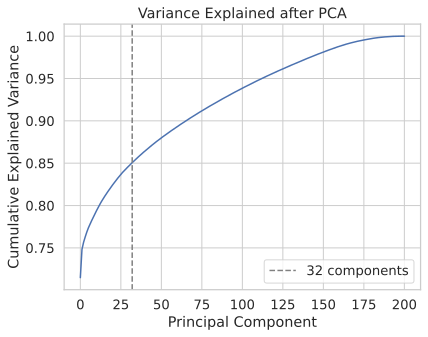

In [22]:
# Plot explained variance
def plot_pca(exp_var_ratios, threshold = 0.85):
    exp_var_cumsum = exp_var_ratios.cumsum()
    t = (exp_var_cumsum < threshold).sum()
    g = sns.lineplot(exp_var_cumsum)
    plt.axvline(x=t, ls='--', color='gray', label=f"{t} components")

    g.set_title("Variance Explained after PCA")
    g.set_xlabel("Principal Component")
    g.set_ylabel("Cumulative Explained Variance")
    g.legend();
    
    return g

g = plot_pca(exp_variances, threshold = 0.85)

Suppose we are comfortable with a model which uses 85% of the variance in our data (in a way, this translates roughly to "15% of the data can be considered outliers"). In this case, we only need to keep 33 components. This is a significant improvement on the original 200+ columns of data.

In [23]:
beers_pca = beers_pca_all[:, :33]

In [24]:
# these correspond to the rows of `df_beers_top`
df_beers_pca = pd.DataFrame(beers_pca, index=df_beers_top.index)

## Similarity

A foundational element of unsupervised learning is the notion of "similarity."" The way(s) in which this idea is defined will direct the rest of the algorithm.

In [25]:
from sklearn.metrics import pairwise_distances

There are several similarity (or distance) metrics, but in this lab we'll investigate a few of the most common ones:

- Euclidean Distance
- Cosine Distance
- Jaccard Distance
- Manhattan Distance

Note: "Similarity" is the complement of "Distance". Typically, similarity metrics exist between 0 and 1, so in general, $\text{distance} = 1 - \text{similarity}$.

### Euclidean Distance

The Euclidean Distance represents **the length of the line which connects two points in a vector space**. For two points on the x-y plane, it is the length of the hypotenuse of the triangle formed by the two points and a right angle between them. In general, for two points $p$ and $q$ in $k$-dimensional data, we have

$$
d_E(\mathbf{p}, \mathbf{q})={\sqrt {(p_{1}-q_{1})^{2}+(p_{2}-q_{2})^{2}+\cdots +(p_{k}-q_{k})^{2}}}
$$

*You can think of $\mathbf{p}$ and $\mathbf{q}$ as two rows of data, for instance.*

In [26]:
points = [(1, 1),
          (1, 2),
          (4, 2)]

dists = pairwise_distances(points, metric='euclidean', n_jobs=-1)
df_dists = pd.DataFrame(data=dists, index=points, columns=points)
df_dists
# g = sns.heatmap(df_dists, annot=True, cmap='Blues');

,"(1, 1)","(1, 2)","(4, 2)"
"(1, 1)",0.000000,1.0,3.162278
"(1, 2)",1.000000,0.0,3.000000
"(4, 2)",3.162278,3.0,0.000000


### Cosine Distance

If each point conotes a vector whose root is at the origin, and head is at the point, then the Cosine Similarity is **the cosine of the angle between the two vectors**. The Cosine *Distance* is 1 minus this value. In general, for two points in $k$-dimensional space, this is

$$
d_C(\mathbf {p}, \mathbf {q})=1 - \cos(\theta )=1 - {\mathbf {p} \cdot \mathbf {q}  \over \|\mathbf {p} \|\|\mathbf {q} \|}={\frac {\sum \limits _{i=1}^{n}{p_{i}q_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{p_{i}^{2}}}}\cdot {\sqrt {\sum \limits _{i=1}^{n}{q_{i}^{2}}}}}}
$$

In fact, this is the same thing as the (Pearson's) correlation coefficient between $\mathbf{p} = \mathbf{x_1} - \overline{\mathbf{x}}_1$ and $\mathbf{q} = \mathbf{x_2} - \overline{\mathbf{x}}_2$ for some vectors $\mathbf{x}$ and $\mathbf{y}$. *Why?*

In [27]:
points = [(1, 1),
          (1, 2),
          (4, 2)]

dists = pairwise_distances(points, metric='cosine', n_jobs=-1)
pd.DataFrame(data=np.round(dists, 3), index=points, columns=points)

,"(1, 1)","(1, 2)","(4, 2)"
"(1, 1)",0.000,0.051,0.051
"(1, 2)",0.051,0.000,0.200
"(4, 2)",0.051,0.200,0.000


### Jaccard Distance

The [Jaccard Similarity](https://en.wikipedia.org/wiki/Jaccard_index) is a consideration of two vectors as if they were sets of items. It represents **the proportion of elements shared between two sets of data.** The more items they share (e.g., maybe each column represents a binary indicator of an item), the higher the Jaccard Similarity. *Note: This measure makes the most sense for binary data.* The Jaccard *Distance* is 1 minus this value:

$$
d_J(\mathbf{p}, \mathbf{q}) = 1 - {|\mathbf{p} \cap \mathbf{q}| \over |\mathbf{p} \cup \mathbf{q}|}
$$

In [28]:
points_tuples = [(0, 0, 1),
                 (1, 1, 0),
                 (1, 1, 1)]

# jaccard similarity requires boolean data
points = np.array(points_tuples).astype(bool)

dists = pairwise_distances(points, metric='jaccard')
pd.DataFrame(data=np.round(dists, 3), index=points_tuples, columns=points_tuples)

,"(0, 0, 1)","(1, 1, 0)","(1, 1, 1)"
"(0, 0, 1)",0.000,1.000,0.667
"(1, 1, 0)",1.000,0.000,0.333
"(1, 1, 1)",0.667,0.333,0.000


### Manhattan Distance

Manhattan Distance, or Taxicab Distance is **the sum of the perpendicular distances along the axes of a vector space, between two points.** So, in two dimensions, it is the total "horizontal" + "vertical" distance between two points.

$$
{\displaystyle d_{\text{T}}(\mathbf {p} ,\mathbf {q} )=\sum _{i=1}^{n}\left|p_{i}-q_{i}\right|}
$$

In [29]:
points = [(1, 1),
          (1, 2),
          (4, 2)]

dists = pairwise_distances(points, metric='manhattan', n_jobs=-1)
pd.DataFrame(data=np.round(dists, 3), index=points, columns=points)

,"(1, 1)","(1, 2)","(4, 2)"
"(1, 1)",0.0,1.0,4.0
"(1, 2)",1.0,0.0,3.0
"(4, 2)",4.0,3.0,0.0


## Clustering

Suppose we had 100 rows of data with two columns: `purchases_per_month` and `spend_per_month`. Consider the following, for a possible scenario.

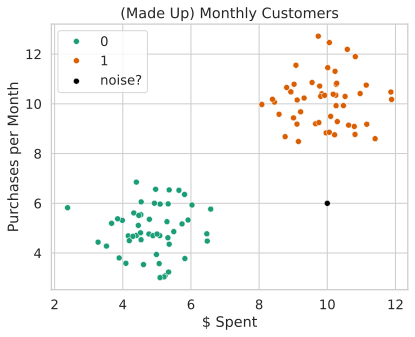

In [30]:
from sklearn.datasets import make_blobs

centers = [(5, 5), (10, 10)]

blobs, blob_labels = make_blobs(n_samples=100, n_features=2, cluster_std=1.0,
                                centers=centers, shuffle=False, random_state=42)

g = sns.scatterplot(x=blobs[:, 0], y=blobs[:, 1], hue=blob_labels, palette='Dark2')
sns.scatterplot(x=[10], y=[6], label='noise?', color='black')

g.set_xlabel('$ Spent')
g.set_ylabel('Purchases per Month')
g.set_title("(Made Up) Monthly Customers");

Visually, we can divide these data into two groups based on their features. Maybe the bottom group represents "frugal" customers, and the top group could be "lavish" customers. But, computationally, the question is a bit more difficult, *especially* when it comes to data with more than three columns.

The purpose of clustering is to use the features of our data to computationally assign each observation to a group, based on some kind of similarity metric. Technically, the term **clustering** refers to grouping data in such a way there could be points leftover; we may call these points "noise". **Partitioning** on the other hand, partitions the data in such a way that *every* point is assigned to one partition. We typically use the term "clustering" to accont for both of these.

In this lab, we will cover the k-Means algorithm, which is still one of the most scalable and interpretable algorithms.

In [31]:
from sklearn.cluster import KMeans

### k-Means

k-Means clustering is a **partitioning** algorithm that divides data into $k$ clusters. Points are assigned to a cluster based on similarity to nearest cluster centroid. The value of $k$ is chosen by the user as a hyperparameter for the algorithm.

    1. Choose `k` centroids (e.g., randomly)
    2. Assign points to cluster based on nearest centroid
    3. Recompute centroids based on each cluster's "average" point
    4. Repeat steps (2) and (3) until algorithm converges

*Interestingly, the boundary regions for KNN can always be reduced to a specific [Vonoroi Diagram](https://en.wikipedia.org/wiki/Voronoi_diagram).*

In [32]:
# suppose we start with 5 clusters (arbitrary at the start)
num_clusters = 5

km = KMeans(n_clusters=num_clusters, n_init='auto')
km.fit(df_beers_pca)

KMeans(n_clusters=5)

In [33]:
df_beers_top['cluster_kmeans'] = km.labels_.astype(str)

In [34]:
df_beers_top[['beer_style', 'cluster_kmeans']].sample(5)

,beer_style,cluster_kmeans
beer_id,,
Red Chair NWPA (55564),American Pale Ale (APA),3
Churchill's Finest Hour 2011 (67034),American Double / Imperial Stout,1
Campus Amber (12187),Belgian Strong Dark Ale,0
Winterstorm (34471),Winter Warmer,0
Drake's 1500 Pale Ale (25095),American Pale Ale (APA),2


**Strengths:**
1. Simple parameter ($k$ clusters)
2. Relatively fast for $n$ points in $d$-dimensions. The runtime is $O(nkdi)$ where $i$ is number of iterations until convergence.
3. Guaranteed to converge.
4. Easy to implement.

**Weaknesses:**
1. Optimal $k$ is often not obvious.
2. Can get trapped in local minima (initial conditions matter).
3. Sensitive to outliers (partitioning not clustering).
4. Scaling affects results.

### Evaluation

There are many different ways to evaluate a clustering algorithm, but here we'll just discuss the following methods:

- Inertia
- Plots

#### Inertia

Inertia roughly translates to "good clustering = points are close to cluster centroids". In essence, we calculate the distances between points and their assigned centroids, and call this "inertia". In fact, this is the main goal of the k-Means algorithm.

$$
I = \sum_{i = 0}^n\min_{\bar{x}_j\in C}\left(\|x_i - \bar{x}_j\|^2\right)
$$

where $x_i$ is each point in the data, $\bar{x}_j$ represents the "average" point of cluster $j$, and $C$ is the colleciton of all clusters. We want $I$ to be as small as possible. *Note: $I \geq 0$, and $I = 0$ only when all points lie at the same location, or the number of clusters = number of points.*

In [35]:
km.inertia_

14922.381278628342

In [36]:
inertias = []

for num_clusters in range(2, 12):
    km = KMeans(n_clusters=num_clusters, n_init='auto')
    km.fit(df_beers_pca)
    
    inertias.append(km.inertia_)

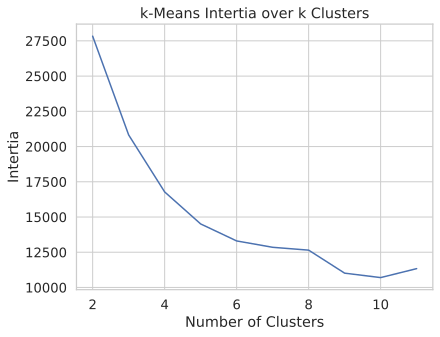

In [37]:
g = sns.lineplot(x=range(2, 12), y=inertias)
g.set_xlabel('Number of Clusters')
g.set_ylabel("Intertia")
g.set_title("k-Means Intertia over k Clusters");

A good rule of thumb for picking the best value in a situation like this is to use the "elbow" method. Essentially, this is the point at which the intertia decreases with diminishing returns. In our case, it looks like our selection of $k=5$ clusters is best for now.

#### Plotting

Of course, a great method is directly plotting the relationships between the clusters you've build and the data. **The plots are up to you, and depend on your data**, but here we'll look at just the top styles of beer, for example.

In [38]:
# top 5 breweries
mask = df_beers_top['beer_style'].value_counts().index[:5]
mask = df_beers_top['beer_style'].isin(mask)

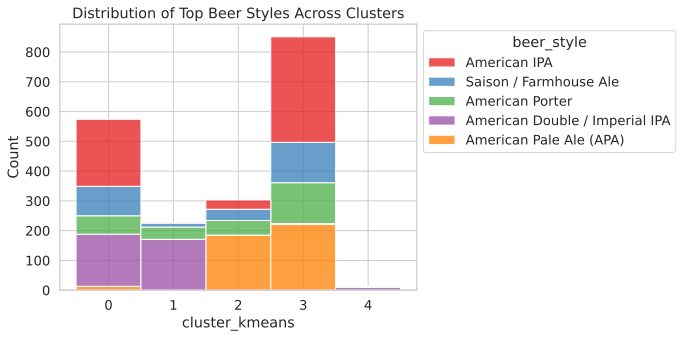

In [39]:
g = sns.histplot(data=df_beers_top[mask].sort_values('cluster_kmeans'),
                 x='cluster_kmeans', 
                 hue='beer_style', palette='Set1', multiple='stack')

g.set_title('Distribution of Top Beer Styles Across Clusters')

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

Here, we can see the some styles of beer are more prevalent in some clusters than others.

## Recommender Systems

A recommender system is an automated system that seeks to suggest whether a given item will be desirable to a user. These are algorithms that aim to provide the most relevant items to a user by **filtering useful information from noise.** For example, suppose there are too many books at the bookstore to browse at once. Let's say I’ve bought a few books related poetry. In this case, a book recommender system might:

    1. Log the interest in poetry
    2. Review other customers’ interests
    3. Reference meta-information on all its books and customers
    4. Suggest a set of products
    
There are two kinds of recommendation:

- Content-Based Filtering
- Collaborative Filtering

We can also combine these two into a sort of "hybrid" method.

### Content-Based Filtering

With Content-Based Filtering, we define relevance using only item information. All we’d need is a matrix of items and their attributes. I.e., we project items into their feature space. The recommendation comes from item similarity. In this case, our definition of similarity is crucial.

#### Calculate Pairwise Distances

In [40]:
# Try metric='euclidean' and metric='cosine', and see what changes!
dists = pairwise_distances(df_beers_pca, metric='cosine')
dists.shape

(8964, 8964)

In [41]:
# Numpy outputs an array here, so we want to get the names of the beers back
dists = pd.DataFrame(data=dists, index=df_beers_pca.index, columns=df_beers_pca.index)

In [42]:
dists.iloc[0:5, 0:5]

beer_id,"""12"" Belgian Golden Strong Ale (44353)","""Alt""ered State (11271)","""Cellar Reserve"" Triple Gold (25108)","""Great Satchmo"" Stout (16575)","""Hop Obama"" Ale (41650)"
beer_id,,,,,
"""12"" Belgian Golden Strong Ale (44353)",0.000000,1.543762,2.086299e-01,1.823624,1.773990
"""Alt""ered State (11271)",1.543762,0.000000,1.524587e+00,0.530140,0.644776
"""Cellar Reserve"" Triple Gold (25108)",0.208630,1.524587,5.551115e-16,1.833697,1.770999
"""Great Satchmo"" Stout (16575)",1.823624,0.530140,1.833697e+00,0.000000,0.178021
"""Hop Obama"" Ale (41650)",1.773990,0.644776,1.770999e+00,0.178021,0.000000


#### Devise "Ranking" Scheme

**Here is where we can get creative!**

Let's say that a user has three beers that they like. We're going to say that a 'likeable' beer is one which is relatively close to all three of these beers. That is, the *sum* of the distances bewteen the 'likeable' beer and the three liked beers is minimal.

Start by selecting three beers and store them in `beers_i_like` then look their distances to other beers.

In [43]:
beers_i_like = ['Belgian Blonde (44506)', 'ÜberFest Pilsner (39361)', '"Cellar Reserve" Triple Gold (25108)']
dists[beers_i_like].head()

beer_id,Belgian Blonde (44506),ÜberFest Pilsner (39361),"""Cellar Reserve"" Triple Gold (25108)"
beer_id,,,
"""12"" Belgian Golden Strong Ale (44353)",1.812991,1.873480,2.086299e-01
"""Alt""ered State (11271)",0.334375,0.473918,1.524587e+00
"""Cellar Reserve"" Triple Gold (25108)",1.811479,1.870383,5.551115e-16
"""Great Satchmo"" Stout (16575)",0.186982,0.078982,1.833697e+00
"""Hop Obama"" Ale (41650)",0.268577,0.124925,1.770999e+00


Now, we sum each of the distances to the favorite beers by row. That is, we are summing 3 numbers for each row.

In [44]:
beers_summed = dists[beers_i_like].sum(axis=1)

In [45]:
beers_summed = beers_summed.sort_values(ascending=True)
beers_summed.head()

beer_id
Blonde Ale (4309)         1.940356
Goose Pils (3011)         1.940844
Sticke Altbier (13683)    1.942495
Summer Bitter (19008)     1.943155
Holiday (75051)           1.946170
dtype: float64

In [46]:
# Filter out the beers used as input using `.isin()`
mask = ~beers_summed.index.isin(beers_i_like)
ranked_beers = beers_summed.index[mask]
ranked_beers = ranked_beers.tolist()

ranked_beers[:5]

['Blonde Ale (4309)',
 'Goose Pils (3011)',
 'Sticke Altbier (13683)',
 'Summer Bitter (19008)',
 'Holiday (75051)']

#### Evaluation

One way to evaluate a recommender system such as this one is to compare the features of the preferred items to the ones which have been recommended.

In [47]:
beers_i_like

['Belgian Blonde (44506)',
 'ÜberFest Pilsner (39361)',
 '"Cellar Reserve" Triple Gold (25108)']

In [48]:
# top 5 recommendations
recommendations = ranked_beers[:5]
recommendations

['Blonde Ale (4309)',
 'Goose Pils (3011)',
 'Sticke Altbier (13683)',
 'Summer Bitter (19008)',
 'Holiday (75051)']

In [49]:
df_eval = df_beers.copy()

# Use `np.where` to create a categorical variable based on boolean series
df_eval['rec_label'] = np.where(df_eval.index.isin(beers_i_like), 'Like',
                       np.where(df_eval.index.isin(recommendations), 'Recommended',
                       'Other'))

In [50]:
df_eval[df_eval.rec_label.isin(['Like', 'Recommended'])] \
        .sort_values('rec_label')

,brewery_name,beer_style,review_overall,beer_abv,rec_label
beer_id,,,,,
"""Cellar Reserve"" Triple Gold (25108)",Beer Works,Tripel,4.000000,9.0,Like
Belgian Blonde (44506),Goose Island Beer Co.,American Blonde Ale,3.250000,4.8,Like
ÜberFest Pilsner (39361),Rogue Ales,German Pilsener,4.000000,5.2,Like
Blonde Ale (4309),Goose Island Beer Co.,American Blonde Ale,3.791667,4.7,Recommended
Goose Pils (3011),Goose Island Beer Co.,German Pilsener,3.802326,5.0,Recommended
Holiday (75051),Goose Island Beer Co.,Belgian Dark Ale,3.750000,5.0,Recommended
Sticke Altbier (13683),Goose Island Beer Co.,Altbier,3.500000,4.5,Recommended
Summer Bitter (19008),Goose Island Beer Co.,English Bitter,3.500000,4.2,Recommended


In a way, this makes sense. Let's put this into a function, and see how things change with new beers and distance metrics

In [51]:
def recommend_beers(beers_i_like, df_pca, num_recs=5, metric='euclidean'):
    # calculate pairwise distances
    dists = pairwise_distances(df_pca, metric=metric)
    dists = pd.DataFrame(data=dists, index=df_pca.index, columns=df_pca.index)
    
    # ranking scheme
    beers_summed = dists[beers_i_like].sum(axis=1)
    beers_summed = beers_summed.sort_values(ascending=True)
    
    # remove preferred beers
    ranked_beers = beers_summed.index[~beers_summed.index.isin(beers_i_like)]
    ranked_beers = ranked_beers.tolist()
    
    # get recommendations (top-ranked)
    recommendations = ranked_beers[:num_recs]
    print("Recommendations: ")
    print('\t' + '\n\t'.join(recommendations))
    
    return recommendations

def rec_eval(beers_i_like, recommendations, df_features):
    df_eval = df_features.copy()

    df_eval['rec_label'] = np.where(df_eval.index.isin(beers_i_like), 'Like',
                                    np.where(df_eval.index.isin(recommendations), 'Recommended',
                                             'Other'))
    
    df_eval = df_eval[df_eval.rec_label.isin(['Like', 'Recommended'])] \
                        .sort_values('rec_label')
    
    return df_eval

With Euclidean distance ...

In [52]:
recommendations = recommend_beers(beers_i_like, df_pca=df_beers_pca, metric='euclidean')

Recommendations: 
	Black Mamba (43067)
	Steelworker's Oatmeal Stout (4603)
	Sehr Crisp Pilsner (62989)
	Fegley's ESB (4602)
	Great Lakes Pumpkin Ale (27151)


In [53]:
rec_eval(beers_i_like, recommendations, df_beers_top)

,brewery_name,beer_style,review_overall,beer_abv,cluster_kmeans,rec_label
beer_id,,,,,,
"""Cellar Reserve"" Triple Gold (25108)",Beer Works,Tripel,4.000000,9.0,1,Like
Belgian Blonde (44506),Goose Island Beer Co.,American Blonde Ale,3.250000,4.8,2,Like
ÜberFest Pilsner (39361),Rogue Ales,German Pilsener,4.000000,5.2,2,Like
Black Mamba (43067),Bear Republic Brewing Co.,Belgian Dark Ale,3.896552,5.3,2,Recommended
Fegley's ESB (4602),Bethlehem Brew Works,Extra Special / Strong Bitter (ESB),3.934783,5.4,3,Recommended
Great Lakes Pumpkin Ale (27151),Great Lakes Brewing Company,Pumpkin Ale,3.846154,5.4,3,Recommended
Sehr Crisp Pilsner (62989),Sixpoint Brewery,German Pilsener,3.958647,5.4,3,Recommended
Steelworker's Oatmeal Stout (4603),Bethlehem Brew Works,Oatmeal Stout,3.892857,5.3,2,Recommended


With Cosine distance ...

In [54]:
recommendations = recommend_beers(beers_i_like, df_pca=df_beers_pca, metric='cosine')

Recommendations: 
	Blonde Ale (4309)
	Goose Pils (3011)
	Sticke Altbier (13683)
	Summer Bitter (19008)
	Holiday (75051)


In [55]:
rec_eval(beers_i_like, recommendations, df_beers_top)

,brewery_name,beer_style,review_overall,beer_abv,cluster_kmeans,rec_label
beer_id,,,,,,
"""Cellar Reserve"" Triple Gold (25108)",Beer Works,Tripel,4.000000,9.0,1,Like
Belgian Blonde (44506),Goose Island Beer Co.,American Blonde Ale,3.250000,4.8,2,Like
ÜberFest Pilsner (39361),Rogue Ales,German Pilsener,4.000000,5.2,2,Like
Blonde Ale (4309),Goose Island Beer Co.,American Blonde Ale,3.791667,4.7,2,Recommended
Goose Pils (3011),Goose Island Beer Co.,German Pilsener,3.802326,5.0,2,Recommended
Holiday (75051),Goose Island Beer Co.,Belgian Dark Ale,3.750000,5.0,2,Recommended
Sticke Altbier (13683),Goose Island Beer Co.,Altbier,3.500000,4.5,2,Recommended
Summer Bitter (19008),Goose Island Beer Co.,English Bitter,3.500000,4.2,2,Recommended


**Caveats of Content-Based Filtering**

- Recommendations biased toward past user preference
    - Consider the feedback loop …
- Suffers from “the cold start problem”
    - **Item recommendations need examples; no data → “cold start”**
    - If you have no product data, recommendations will be mal-informed
- Diversity of recommendation space is diminished
    - We can only work within neighborhoods of past items
- Cross domain recommendations are difficult
    - Think about recommending movies based on podcasts

### Collaborative

Here, we use other users’ history to predict new users’ preference. We define relevance using only user-item relationships, based on a user-item matrix containing “ratings” as values.

In [56]:
# Let's restrict our dataset to the top reviewers.
n = 100

# The number of beers reviewed for each user
reviewer_counts = df_beer_reviews.groupby('review_profilename')['beer_beerid'] \
                                 .nunique().sort_values(ascending=False)

top_n_reviewers = reviewer_counts.index[:n]

# this is the data we want
df_filtered = df_beer_reviews[df_beer_reviews['review_profilename'] \
                              .isin(top_n_reviewers)].copy()
df_filtered.shape

(167248, 13)

In [57]:
df_filtered[['beer_beerid', 'beer_name', 'review_profilename', 'review_overall']].head()

,beer_beerid,beer_name,review_profilename,review_overall
177797,6394,Bert Grant's Fresh Hop Ale,Gavage,3.0
613219,5703,Black Marlin Porter,hopdog,3.5
549544,39397,Schlafly Bière De Garde,jpm30,4.0
711685,8848,Dark Horse Boffo Brown Ale,WVbeergeek,4.5
840060,8716,Slipknot Imperial IPA (Brewmaster Reserve),barleywinefiend,2.5


#### Collect Users as Features

What we want is a matrix with users on one axis (e.g., columns), and items on the other axis (e.g., rows). Here, we start by grouping our data to get an aggregate reprsentative value for each item-user combination, and then use `unstack` to widen the data.

In [58]:
# create a useful index
df_filtered['beer_id'] = df_filtered['beer_name'] + ' (' + df_filtered['beer_beerid'].astype(str) + ')'

In [59]:
# For each beer (row), what is the average review score for each user (column)
df_beer_user = df_filtered.groupby(["beer_id", "review_profilename"])['review_overall'] \
                          .mean()
df_beer_user.head()

beer_id                       review_profilename
! (Old Ale) (57645)           tpd975                4.0
"100" (49236)                 Mora2000              4.0
                              hopdog                4.0
"33" Export (30080)           BEERchitect           3.0
"76" Anniversary Ale (51029)  DoubleJ               4.0
Name: review_overall, dtype: float64

In [60]:
# convert to a wide version
df_beer_user = df_beer_user.unstack()
df_beer_user.head()

review_profilename,AgentZero,BEERchitect,BeerFMAndy,Beerandraiderfan,Bighuge,Billolick,Bitterbill,BlackHaddock,Brad007,Brent,...,smcolw,stcules,tavernjef,tempest,tpd975,weeare138,wl0307,womencantsail,woodychandler,zeff80
beer_id,,,,,,,,,,,,,,,,,,,,,
! (Old Ale) (57645),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
"""100"" (49236)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""33"" Export (30080)",NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""76"" Anniversary Ale (51029)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
"""76"" Anniversary Ale With English Hops (55510)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


In [61]:
df_beer_user.isna().sum() / df_beer_user.shape[0]

review_profilename
AgentZero           0.953717
BEERchitect         0.920552
BeerFMAndy          0.955990
Beerandraiderfan    0.949693
Bighuge             0.939706
                      ...   
weeare138           0.934339
wl0307              0.933781
womencantsail       0.905534
woodychandler       0.950885
zeff80              0.928116
Length: 100, dtype: float64

**How should we handle missing values here?** What does it mean for a beer *not* to be reviewed by a user? Should we treat these the same as the situations where a user reviewed a beer, and rated it zero? What if we used a negative number, how would that affect our distances/similarities between beer-user entities? What if we used the average value for each column, can we assume that a beer unreviewed by user $x$ will have their average beer rating?

What if we assume (for the time being) that an unreviewed beer has an (impossible) rating of -1. This way, we can capture the fact that user hasn't reviewed that beer. It also comes in handy later when trying to spot the beers that have been rated vs. those which have not.

In [62]:
df_beer_user.fillna(-1, inplace=True)

Recall that Singular Value Decomposition (SVD) is a method we can use to understand latent "topic directions" in text data. So, given a document-term matrix, we can get an idea for the kinds of topics that exist in the data (i.e., the ways words are used in documents). With our user-item data, we can use SVD to understand sort of "*usage* directions". In this way, given a user-item matrix, we get an idea for the ways items are used by users given our data set.

<center>
    <img width='65%' src="http://zwmiller.com/projects/images/svd_breakdown.png">
</center>

Traditionally, we'll want to reduce our number of *usage directions* (i.e., the number of columns in the middle matrix on the right of the equals sign, above) to some number less than the total number of users in our data set. This way, we can look at our data from the perspective of groups (the directions) and weights with which they're associated (how strongly a user/item is correlated in a direction). *In fact, we can use these weights to assign users (or items, for that matter) to groups.*

[SciPy](https://docs.scipy.org/doc/scipy/index.html) is another Python library we will see more of in a later lesson. It's built to manage all kinds of mathematical operations such as linear algebra, signal processing, etc. Here, we'll use it's implementation of SVD so that we can capture all three of these matrices $U$, $\Sigma$, and $V$, since SKLearn's `PCA` only gives us the first two matrices.

In [63]:
from scipy.linalg import svd

In [64]:
beer_usage, usage, usage_user = svd(df_beer_user, full_matrices=False)

In [65]:
# For each beer, how much of their use (rating) is captured by each usage type?
df_beer_usage = pd.DataFrame(data=beer_usage, index=df_beer_user.index)

In [66]:
# For each user, how much of their activity is captured by each usage (rating scheme) type?
df_usage_user = pd.DataFrame(data=usage_user, columns=df_beer_user.columns)
df_user_usage = df_usage_user.T

- `df_beer_usage` is now a matrix where each row represents a beer, and each column represents a kind of *usage*. If we look at any row (beer), the columns tell us how much information about that beer can be gathered solely by looking at it's usage along each usage type
- `df_user_usage` is a matrix where each row is a kind of usage, and the columns are users. Similar to the above, it tells us how much information about that user can be gathered just by looking at their activity in some usage type.
- `usages` contains the sort of variety of users/beers that are represented by each usage type. 

#### Similar User Activity

Recall that the `usages` came from `svd`, and it represents the singular values (the *weights*) of the Singular Value Decomposition. Each singular value tells us *how much* a principal component ("usage type") tells us about the user or item. So, naturally, if we take any singular value `usage[i]` and divide it by the sum of all the usages `usage[i] / usage.sum()`, we have the amount of "explained variance" that the `i`th singular value provides. 

Also, `usages` is **naturally sorted** in descending order by the `svd` algorithm.

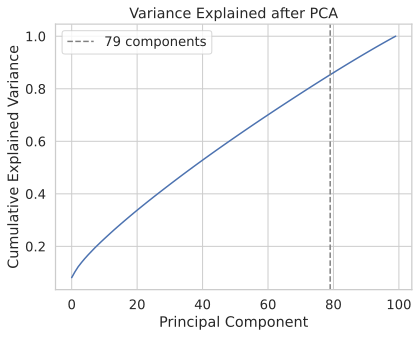

In [67]:
# plot the explained variance of each of these usage types
exp_var_ratios = usage / usage.sum()

g = plot_pca(exp_var_ratios, threshold = 0.85)

Notice that it takes many more principle components to capture 85% of the variance in this data. In other words, there are more than 80 different ways to review beer that are relatively distinct from one another.

In [68]:
# To keep 85% of the variance, let's consider the first 80 usage types (principal components)
dists_users = pairwise_distances(df_user_usage.iloc[:, :80], metric='euclidean')
dists_users = pd.DataFrame(dists_users, index=df_user_usage.index, columns=df_user_usage.index)

In [69]:
def get_user_neighbors(user, neighborhood=10):
    '''
    Given a user, return the closest users by the `dists_users` matrix
    '''
    neighbors = dists_users[user].sort_values()[:neighborhood]
    
    return neighbors

In [70]:
df_user_usage.index[1]

'BEERchitect'

In [71]:
# for example
neighbors = get_user_neighbors('BEERchitect')
neighbors

review_profilename
BEERchitect         1.490116e-08
Brent               9.167095e-01
LilBeerDoctor       1.058884e+00
OWSLEY069           1.069765e+00
merlin48            1.073062e+00
BeerFMAndy          1.082519e+00
dyan                1.101219e+00
Beerandraiderfan    1.104994e+00
largadeer           1.112309e+00
GClarkage           1.129622e+00
Name: BEERchitect, dtype: float64

**Diverse Reviewers**

First, we can take a look at the beer ratings for top users, and those closest to them using usage types (from `dists`, above).

In [72]:
# count non-negative values (i.e., beers with reviews), and sort
top_users = (df_beer_user > 0).sum(axis=0) \
                              .sort_values(ascending=False).index[:10]
top_users

Index(['northyorksammy', 'BuckeyeNation', 'mikesgroove', 'Thorpe429',
       'womencantsail', 'ChainGangGuy', 'Phyl21ca', 'brentk56', 'NeroFiddled',
       'oberon'],
      dtype='object', name='review_profilename')

In [73]:
def plot_usage(user, neighborhood=10):
    # Get the `neighborhood` closest neighbors
    neighbors = get_user_neighbors(user, neighborhood).index.tolist()
    
    # build array of review values for beers reviewed by neighbors
    mask = df_filtered['review_profilename'].isin(neighbors)
    df_plot = df_filtered[mask][['review_profilename', 'beer_style', 'review_overall']]
    df_plot = df_plot.groupby(['beer_style', 'review_profilename'])['review_overall'] \
                     .mean().unstack()

    df_plot = df_plot.loc[:, neighbors] \
                     .sort_values(user, ascending=False) \
                     .dropna(how='all')
    
    # We'll only annotate the heatmap if the text is easier to see
    df_annot = df_plot.round(2) if df_plot.shape[0] <= 20 else None
    
    # We're sure to be intentional about a "center" point
    sns.heatmap(df_plot,
                annot=df_annot,
                cmap='Blues',
                center=3);  # Maybe below a 3 is bad, above is good

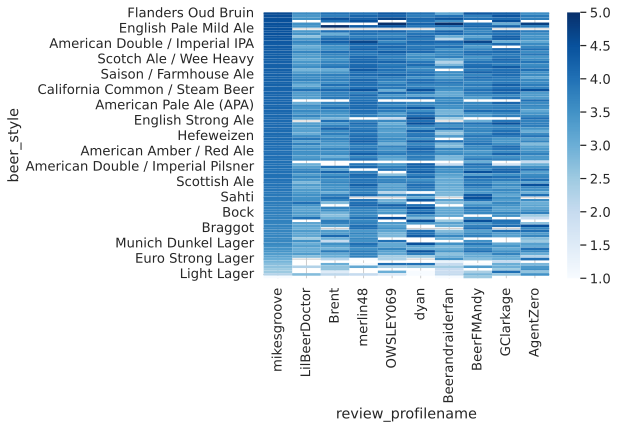

In [74]:
plot_usage('mikesgroove')

Based off this, could we conclude this is a good recommender?

#### Recommendation

Say for some user, we take the top `m` closest users, and recommend `r` different beers

In [75]:
user = 'dyan'

In [76]:
# We consider the 20 closest users (reviewers) to choose untried beers
n_neighbors = 20

neighbors = get_user_neighbors(user, n_neighbors+1)
neighbors = neighbors[1:]  # We don't want to include the user themself
neighbors

review_profilename
largadeer           0.451904
LilBeerDoctor       0.638622
BeerFMAndy          0.664202
Brent               0.696082
Beerandraiderfan    0.712291
merlin48            0.727788
AgentZero           0.733568
cokes               0.734062
GClarkage           0.745987
OWSLEY069           0.754949
DoubleJ             0.760258
ZAP                 0.763039
Dogbrick            0.790460
HopHead84           0.790914
mothman             0.825056
beerthulhu          0.828447
jpm30               0.833905
Bitterbill          0.849056
Vancer              0.864312
Bighuge             0.900526
Name: dyan, dtype: float64

In [77]:
# Look at *untried* beers among the neighboring users
untried_beers = df_beer_user[user] < 0
df_rec = df_beer_user.loc[untried_beers, neighbors.index].copy()

df_rec = df_rec.replace(-1, np.nan)  # Replace the un-rated beers with NAN values
df_rec = df_rec.dropna(how='all')    # Only keep rows where at least one neighbor rated the beer

df_rec

review_profilename,largadeer,LilBeerDoctor,BeerFMAndy,Brent,Beerandraiderfan,merlin48,AgentZero,cokes,GClarkage,OWSLEY069,DoubleJ,ZAP,Dogbrick,HopHead84,mothman,beerthulhu,jpm30,Bitterbill,Vancer,Bighuge
beer_id,,,,,,,,,,,,,,,,,,,,
"""76"" Anniversary Ale (51029)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Hop Obama"" Ale (41650)",NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Jessica & Brendan's"" Bridal Ale (60596)",NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""Just One More"" Scotch Ale (71602)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
"""Not Guilty"" 1924 Deer Brand (49214)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ølfabrikken Sort Jul (41553),NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ølfabrikken ØL (Russian Imperial Chocolate Stout) (33941),NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Über Pils (21578),NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,4.0,NaN,NaN,3.5,3.5,NaN,NaN,4.0,4.0,NaN,NaN,4.5


In [78]:
# Get the average rating among the top `n_neighbors` of our user (HOW COULD WE SMARTER ABOUT THIS?)
avg_beer_rating = np.nanmean(df_rec, axis=1)
avg_beer_rating = pd.Series(index=df_rec.index, data=avg_beer_rating)
avg_beer_rating.sort_values(ascending=False, inplace=True)

# Return up to `n_recommendations`
n_recommendations = 5
avg_beer_rating[:n_recommendations]

beer_id
Smooth India Pale Ale (1156)                            5.0
Smokey The Rye Beer (15543)                             5.0
Hop Valley India Pale Ale (42352)                       5.0
Southampton Abbey Single (8534)                         5.0
Listermann's Enter The Beagle India Pale Ale (51295)    5.0
dtype: float64

In [79]:
# Put all this into a function
def get_recommendations(user, n_recommendations=5, n_neighbors=20):
    neighbors = get_user_neighbors(user, n_neighbors+1)
    neighbors = neighbors[1:]  # We don't want to include the user themself
    
    untried_beers = df_beer_user[user] < 0
    df_rec = df_beer_user.loc[untried_beers, neighbors.index].copy()

    df_rec = df_rec.replace(-1, np.nan)  # Replace the un-rated beers with NAN values
    df_rec = df_rec.dropna(how='all')  # Only keep rows where at least one neighbor rated the beer
    
    # Get the average rating among the top `n_neighbors` of our user
    avg_beer_rating = np.nanmean(df_rec, axis=1)
    avg_beer_rating = pd.Series(index=df_rec.index, data=avg_beer_rating)
    avg_beer_rating.sort_values(ascending=False, inplace=True)

    # Return up to `n_recommendations`
    return avg_beer_rating[:n_recommendations]

In [80]:
user = 'Thorpe429'

In [81]:
get_recommendations(user)

beer_id
Proving Ground IPA (15217)         5.0
Founders Looking Glass (60584)     5.0
Thunderstorm Summer Ale (19307)    5.0
Fra Til (From To) (45993)          5.0
Jodocus Weizenbock (29074)         5.0
dtype: float64

# Exercises

## Exercise 1

Write a function called `euclidean` which calculates the Euclidean distance between two points (of any `k` dimensions), using only vanilla Python (no packages) and NumPy. This should return a single value.

If you can, adjust your function to calculate *pairwise* Euclidean distances for any number of points (i.e., return a matrix).

<br>
<h4>This <code>euclidean</code> implementation returns the distance between two points (i.e., it just returns a single value)</h4>

In [82]:
def euclidean(point_1, point_2):
    points_dim = len(point_1)
    square_sum = 0

    for dim in range(points_dim):
        square_sum += (point_1[dim] - point_2[dim]) ** 2

    euclidean_distance = square_sum ** 0.5
    return euclidean_distance

In [83]:
import random

random.seed(42)
points_dim = 100

point_1 = [random.random() for _ in range(points_dim)]
point_2 = [random.random() for _ in range(points_dim)]

euclidean(point_1, point_2)

4.1137311004593125

<br>
<h4>This <code>euclidean</code> function returns a matrix of pairwise distance values of multiple points (i.e., returns a matrix)</h4>

In [84]:
def euclidean(*points):
    num_points = len(points)
    points_dim = len(points[0])

    distance_matrix = [[0 for _ in range(num_points)] for _ in range(num_points)]

    for i in range(num_points):
        for j in range(num_points):
            if i == j: continue
            square_sum = 0

            for dim in range(points_dim):
                square_sum += (points[i][dim] - points[j][dim]) ** 2
        
            euclidean_distance = square_sum ** 0.5
            distance_matrix[i][j] = euclidean_distance

    return distance_matrix

In [85]:
num_points = 5
points_dim = 100

random.seed(42)
points = [[random.random() for _ in range(points_dim)] for _ in range(num_points)]

result = euclidean(*points)
result

[[0,
  4.1137311004593125,
  4.211731462988442,
  4.488580637103783,
  4.236911630647115],
 [4.1137311004593125,
  0,
  3.7903316400104314,
  3.845684909349288,
  3.958375348016543],
 [4.211731462988442,
  3.7903316400104314,
  0,
  4.24345553180371,
  4.243371068336661],
 [4.488580637103783,
  3.845684909349288,
  4.24345553180371,
  0,
  4.352217414287757],
 [4.236911630647115,
  3.958375348016543,
  4.243371068336661,
  4.352217414287757,
  0]]

In [86]:
len(result), len(result[0])

(5, 5)

It has the shape `(num_points, num_points)`

## Exercise 2

Let `r` be some value less than `df_user_usage.shape[1]`. For example, `r = 80` corresponds to roughly 85% of the variance in the user data.

Use your function from Exercise 1 and the `df_user_usage.iloc[:, :r]` dataframe to calculate the distance between any two users. Interpret your results for a random selection of two users compared to another selection of two *other* users.

**Bonus**

Set `r = None`. Given the fact that `df_user_usage` came after PCA, explain the distances calculated in Exercise 2.

In [94]:
r = 80

distance_matrix = euclidean(*df_user_usage.iloc[:, :r].values)

distance_matrix[0][:10]

[0,
 1.1532376045756803,
 0.7378110302573363,
 0.7256640351498509,
 0.9696759405183996,
 1.1347277297893819,
 0.998414947668348,
 1.0674704353215667,
 1.0558279925143539,
 0.6766539103041033]

In [88]:
user_1 = random.randint(1, r)
user_2 = random.randint(1, r)
user_12_distance = distance_matrix[user_1][user_2]

user_3 = random.randint(1, r)
user_4 = random.randint(1, r)
user_34_distance = distance_matrix[user_3][user_4]

user_12_distance, user_34_distance

(1.3320890616322218, 1.2682368840323612)

Here the first 2 users have distance value of `1.4030436223867184` while the other 2 users have a distance have `1.138623161291217`, which means that the later 2 users are much more similar compared to the first 2 users.

### Bonus Question

All the distances in the complete distance matrix will be very close due to the values of `df_user_usage` being obtained from the SVD, more specifically in SVD the `V` matrix. The matrix `V` is an orthogonal matrix, and all the individal columns have a unit distance.

Since, the columns in the matrix are both orthogonal and have length of 1, so the vectors are perpendicular to each oter and have unit length. Therefore the distance between these vectors in a 2D space would be &radic;2 (Pythagorean theorem). Hence all the values in the distance matrix are close &radic;2, as seen in the code below using `r = None`

In [89]:
r = None

distance_matrix = euclidean(*df_user_usage.iloc[:, :r].values)
distance_matrix

[[0,
  1.414213562373095,
  1.4142135623730947,
  1.4142135623730951,
  1.4142135623730956,
  1.4142135623730954,
  1.4142135623730954,
  1.4142135623730951,
  1.414213562373095,
  1.4142135623730954,
  1.4142135623730951,
  1.414213562373095,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730954,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730956,
  1.4142135623730951,
  1.4142135623730951,
  1.414213562373095,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730954,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.414213562373095,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730956,
  1.4142135623730951,
  1.4142135623730954,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730951,
  1.4142135623730954,
  1.414213562373095,
  1.4142135623730951,
  1.414213562373095,
  1.41421356